We can prove that under assumption $ (H): \rho(|| \Phi ||) < 1, $ the norm kernel matrix satisfies the following equation $$ (C): || \Phi || = I - \Sigma^{1/2} M || c ||^{-1/2} \mbox{ with } M \in O_d (R) \mbox{ and } \int_0^\infty \phi^{ij} \ge 0$$

# Simulation of the Hawkes process with $d$=10

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
from mlpp.hawkesnoparam.estim import Estim
import mlpp.pp.hawkes as hk
import whma.simulation as simu
from mlpp.base.utils import TimeFunction
from whma.metrics import rel_err, rank_corr

In [2]:
# simulation of Hawkes processes
d = 20
mu = 0.5 * np.ones(d)
mus = simu.simulate_mu(d, mu=mu)
blocks = [5,5,10]
L = []
for x in blocks:
    L.append(np.random.rand(x, x))
Alpha_truth = scipy.linalg.block_diag(*L) / 6
# add noise
Alpha_truth += 0.01
Beta = np.random.rand(d**2).reshape((d,d))

In [3]:
#Alpha_truth[2,8] += 0.2

/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


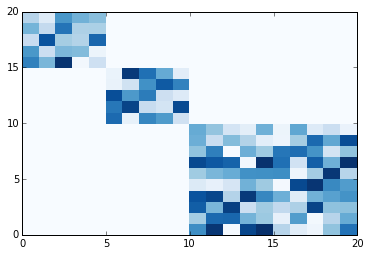

In [4]:
plt.pcolor(Alpha_truth[::-1],cmap=plt.cm.Blues)
plt.show()
plt.close()

In [5]:
_, s, _ = np.linalg.svd(Alpha_truth)
print(s.max())
assert s.max() < 1, "Alpha_truth cannot generate a stable Hawkes process"

0.942083485891


In [6]:
kernels = [[hk.HawkesKernelExp(a, b) for (a, b) in zip(a_list, b_list)] for (a_list, b_list) in zip(Alpha_truth, Beta)]
h = hk.Hawkes(kernels=kernels, mus=list(mus))
h.simulate(10000)
estim = Estim(h, n_threads=8)

## Correlation matrix

In [7]:
from whma.utils import corr_matrix
Corr = corr_matrix(estim)

/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


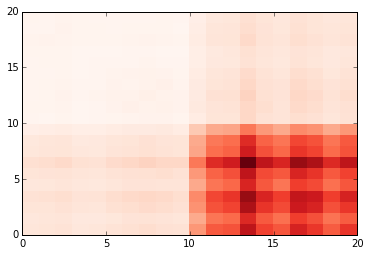

In [8]:
plt.pcolor(Corr[::-1],cmap=plt.cm.Reds)
plt.show()
plt.close()

# Estimation procedure

In [9]:
from whma.solver import admm
import whma.prox as prox
X0 = np.eye(d)
#X0 = np.ones(d**2).reshape(d,d)
rho = 0.001
maxiter = 10000

## objective = squared Frobenius

In [10]:
# main step
X_frob = admm(estim, prox.sq_frob, X0, X0, Alpha_truth, rho=rho, maxiter=maxiter)

||X1 - X_2|| =  2.60578861651e-08
||X2 - X_3|| =  1.72506101779e-15
||U1|| =  0.00462202832494
||U2|| =  0.000393955743712
||U3|| =  6.07857808452e-15
||U4|| =  0.00200812649977
||U5|| =  0.000810104281194


/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


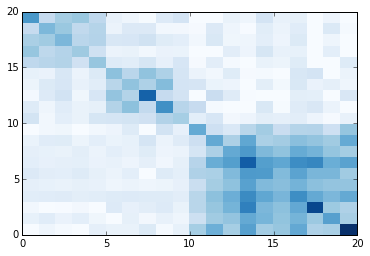

In [11]:
plt.pcolor(X_frob[::-1],cmap=plt.cm.Blues)
plt.show()
plt.close()

In [12]:
print("RelErr = ", rel_err(Alpha_truth, X_frob))
print("RankCorr = ", rank_corr(Alpha_truth, X_frob))

RelErr =  0.796612453774
RankCorr =  0.30070318071


## objective = \ell_1 norm

In [13]:
# main step
X_l1 = admm(estim, prox.l1, X0, X0, Alpha_truth, rho=rho, maxiter=maxiter)

||X1 - X_2|| =  6.09453618391e-08
||X2 - X_3|| =  3.62816992313e-08
||U1|| =  0.0666923623412
||U2|| =  0.00464480429447
||U3|| =  0.000499888019593
||U4|| =  0.0350389638056
||U5|| =  0.0110588883663


/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


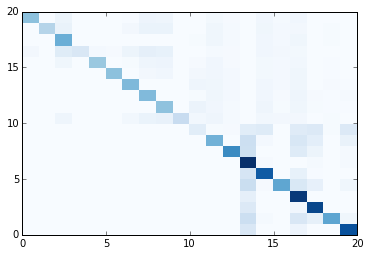

In [14]:
plt.pcolor(X_l1[::-1],cmap=plt.cm.Blues)
plt.show()
plt.close()

In [15]:
print("RelErr = ", rel_err(Alpha_truth, X_l1))
print("RankCorr = ", rank_corr(Alpha_truth, X_l1))

RelErr =  1.55195597765
RankCorr =  0.273029484522


## objective = nuclear norm

In [16]:
# main step
X_nuc = admm(estim, prox.nuclear, X0, X0, Alpha_truth, rho=rho, maxiter=maxiter)

||X1 - X_2|| =  4.96578521926e-10
||X2 - X_3|| =  1.1626847228e-15
||U1|| =  0.0146369962789
||U2|| =  0.00426789681928
||U3|| =  8.06675973944e-16
||U4|| =  0.00784068674747
||U5|| =  0.00611584818411


/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


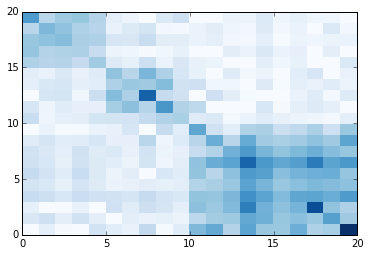

In [17]:
plt.pcolor(X_nuc[::-1],cmap=plt.cm.Blues)
plt.show()
plt.close()

In [18]:
print("RelErr = ", rel_err(Alpha_truth, X_nuc))
print("RankCorr = ", rank_corr(Alpha_truth, X_nuc))

RelErr =  0.945275318842
RankCorr =  0.304522351394


## method = matrix Riccati equation

In [19]:
from scipy.linalg import solve_continuous_are
from whma.utils import empirical_sqrt_mean, empirical_sqrt_cross_corr
Lambda = empirical_sqrt_mean(estim.lam)
diagD, O = empirical_sqrt_cross_corr(estim)
A = np.zeros((d, d))
B = np.dot(O,np.dot(np.diag(diagD),O.T))
R = np.eye(d)
Q = np.diag(Lambda)

In [20]:
R_ric = solve_continuous_are(A, B, Q, R)
X_ric = np.eye(d) - R_ric

/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


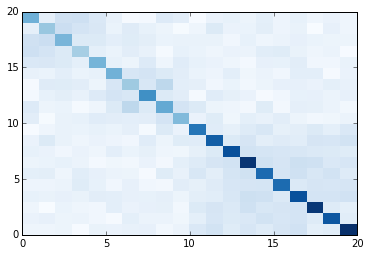

In [21]:
plt.pcolor(X_ric[::-1],cmap=plt.cm.Blues)
plt.show()
plt.close()

In [22]:
print("RelErr = ", rel_err(Alpha_truth, X_ric))
print("RankCorr = ", rank_corr(Alpha_truth, X_ric))

RelErr =  1.29550887401
RankCorr =  0.282936454958
